|Name|ANR|
|----|---|
|Lisseth Escalante||658342|

# Relationship between countries' economic importance and countries' information available on the internet

## Question

Is there a relationship between countries' economic importance and countries' information available on the internet?

## Motivation

The internet has changed the way we access to information. It provides a wealth of information and resources available that grow continuously, in which anyone can publish and contribute in its expansion. With such broad data and ease of sharing information, the representativeness of each country in the internet media turns out central to understand how we see countries in the world. A country’s economic importance arises as a possible factor related to how we see a country. Therefore, in this project, I study the relationship between countries’ economic importance and countries’ information available on the internet.

## Method

I use country's gross domestic product (GDP) as an indicator of country's economic importance. I obtained GDP data from a general function I created ([see below](#general_function)) based on an interface to find and request information from World Bank data API’s, [wbdata](http://wbdata.readthedocs.io/en/latest/). The selection includes GDP data for 2016, in U.S. dollars. I collected data from google estimates search results, using a function for web scraping ([see below](#search_results)), to measure countries' information available on the internet. The selection includes web general results and web news results in [Google](http://google.com). I present [visualization](#visualization) of the relationship between variables and conduct [Spearman's rank correlation](#spearman).

## Answer

Yes. There is a positive statistically significant correlation between countries' economic importance measured by GDP and countries' information available on the internet measured by search results in Google. 

## Extracting data

Let’s first import necessary libraries for the whole project.

In [1]:
#libraries imported
import wbdata #interface to find and request information from the World Bank's various databases
import pandas as pd 
import numpy as np
import datetime 
import requests
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
from scipy import stats

As the World Bank data includes countries as well as regions, let's subset the codes that correspond only to individual economies.

In [2]:
#economies' codes
file="http://databank.worldbank.org/data/download/site-content/CLASS.xls"
df_file=pd.read_excel(file, index_col=0, usecols=[2,3])
df_file.columns = ['Code']
df_country=df_file.loc['Afghanistan':'Zimbabwe']
country_code=df_country['Code'].tolist()

Next, let's find out the code of the indicator of interest: GDP.

In [3]:
#search data label indicator
wbdata.get_source() #to select database of interest
wbdata.search_indicators('GDP', source=2) #filter indicator in databate of interest

11	Africa Development Indicators
36	Statistical Capacity Indicators
31	Country Policy and Institutional Assessment
41	Country Partnership Strategy for India (FY2013 - 17)
1 	Doing Business
30	Exporter Dynamics Database ��� Indicators at Country-Year Level
12	Education Statistics
13	Enterprise Surveys
28	Global Financial Inclusion
33	G20 Financial Inclusion Indicators
14	Gender Statistics
15	Global Economic Monitor
27	Global Economic Prospects
32	Global Financial Development
21	Global Economic Monitor Commodities
55	Commodity Prices- History and Projections
34	Global Partnership for Education
29	The Atlas of Social Protection: Indicators of Resilience and Equity
16	Health Nutrition and Population Statistics
39	Health Nutrition and Population Statistics by Wealth Quintile
40	Population estimates and projections
18	IDA Results Measurement System
45	Indonesia Database for Policy and Economic Research
6 	International Debt Statistics
54	Joint External Debt Hub
25	Jobs
37	LAC Equity Lab
19	M

<a name="general_function"></a>The following represents a general function to extract data from World Bank in a given period for given countries. I apply this function to extract GDP data of all countries in 2016.

In [5]:
#to get an indicator for certain years for certain countries with datetime 
def country_data(indicator_code, indicator_label, start, end, country=country_code):
    """Extract data from World Bank from one indicator for years and countries specified"""
    indicator = {indicator_code: str(indicator_label)}
    period=(datetime.datetime(start,1,1), datetime.datetime(end,12,31))
    df=wbdata.get_dataframe(indicator, country, period)
    return df[[str(indicator_label)]]

#the specific indicator I want to get 
gdp=country_data("NY.GDP.MKTP.CD", "gdp", 2016, 2016)

#to drop missing values
gdp.dropna(inplace=True)

<a name="search_results"></a>Next, I obtained countries' search results.

In [6]:
#google search results function
def google_search(countries, t='Web'):
    """Extract number of search results for a dataframe of countries"""
    for country in countries.index:
        #print (country)
        if t is 'Web': 
            urlt = 'https://www.google.com/search?q='+str(country)
        if t is 'News': 
            urlt = 'https://www.google.com/search?tbm=nws&q='+str(country)
        rt = requests.get(urlt)
        st = BeautifulSoup(rt.text, 'lxml')
        result_stats_t = st.find(id='resultStats')
        results_t=re.findall('[0-9]', str(result_stats_t))
        results=[int(''.join(results_t))]
        #print (results)
        countries.loc[str(country), t] = int(''.join(results_t))

In [7]:
#google search results for web, be aware this can take around 3 minutes to execute due to number of requests
google_search(gdp)

In [8]:
#google search results for news, be aware this can take around 3 minutes to execute due to number of requests
google_search(gdp, t='News')

## Analysis

Preview of final data: five largest and five smallest economies

In [9]:
#function to preview final data
def table(data, sort, hlabel, tlabel):
    data.columns=data.columns.str.capitalize()
    data = data.sort_values(by=str(sort), ascending=False)
    table = pd.concat([data.head(5)/1000000, data.tail(5)/1000000], keys=[str(hlabel),str(tlabel)])
    table.rename(columns=lambda x: x+' (in millions)', inplace=True)
    table_d=table.style.format('{0:,.2f}')
    return table_d

In [10]:
#display data for the five largest and the five smallest economies 
table(gdp, 'Gdp', 'Largest', 'Smallest')

I classify the economies as follows:<br/> 
* Largest: economies with a GDP greater than 100 billion US dollars
* Middle: economies with a GDP between 10 billion US dollars and 100 billion US dollars
* Smallest: economies with a GDP smaller than 10 billion US dollars

In [95]:
#group of countries created
largest = gdp[100000000000<=gdp.Gdp].sort_values(by=['Gdp'], ascending=False)
middle = gdp[(10000000000<gdp.Gdp) & (gdp.Gdp<100000000000)].sort_values(by=['Gdp'], ascending=False)
smallest = gdp[gdp.Gdp<=10000000000].sort_values(by=['Gdp'])

In [96]:
#function for graphs
def graph(group, column1, column2, column3, color, title):
    fig = plt.figure(figsize=(11,4))
    sub1 = fig.add_subplot(131)
    sub1.set_title(column1)
    sub1 = group[column1].head(5).plot.barh(color=color)
    sub2 = fig.add_subplot(132)
    sub2.set_title(column2)
    sub2 = group[column2].head(5).plot.barh(color=color)
    sub2.set_ylabel(" ")
    sub2.set_yticks([])
    sub3 = fig.add_subplot(133)
    sub3.set_title(column3)
    sub3 = group[column3].head(5).plot.barh(color=color)
    sub3.set_ylabel(" ")
    sub3.set_yticks([])
    if group is largest:
        sub1.invert_yaxis()
        sub2.invert_yaxis()
        sub3.invert_yaxis()
    plt.suptitle(title)
    plt.subplots_adjust(wspace=0.03)
    plt.show()

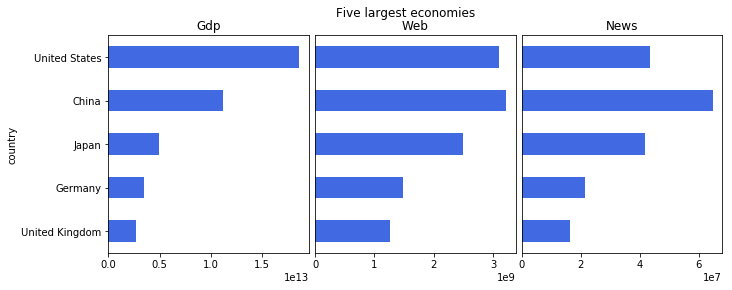

In [97]:
#graph of the five largest economies
graph(largest, 'Gdp', 'Web', 'News', 'royalblue', 'Five largest economies')

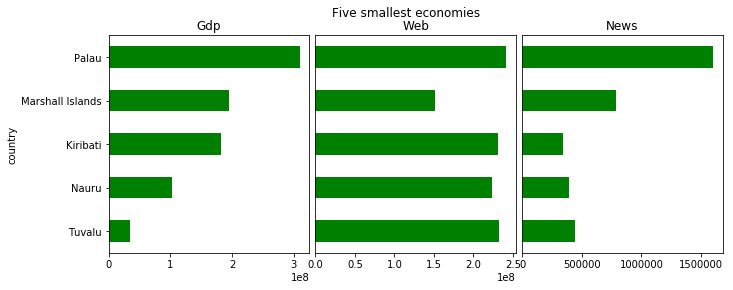

In [98]:
#graph five smallest economies
graph(smallest, 'Gdp', 'Web', 'News', 'g', 'Five smallest economies')

<a name="visualization"></a>Visualization of relationship between variables, expressed on logarithmic axes.

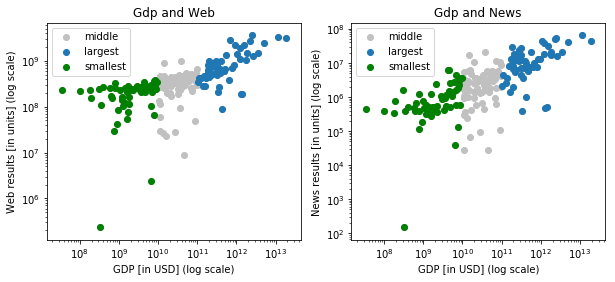

In [99]:
#graph relationship GDP-Web, GDP-News
fig = plt.figure(figsize=(10,4))
sub1 = fig.add_subplot(121)
sub1.set_title('Gdp and Web')
sub1.set_xlabel('GDP [in USD] (log scale)')
sub1.set_ylabel('Web results [in units] (log scale)')
sub1.set_xscale('log') 
sub1.set_yscale('log')
sub1.scatter(gdp['Gdp'], gdp['Web'], color='silver')
sub1.scatter(largest['Gdp'], largest['Web'])
sub1.scatter(smallest['Gdp'], smallest['Web'], color='g')
plt.legend(['middle','largest','smallest'])
sub2 = fig.add_subplot(122)
sub2.set_title('Gdp and News')
sub2.set_xlabel('GDP [in USD] (log scale)')
sub2.set_ylabel('News results [in units] (log scale)')
sub2.set_xscale('log')
sub2.set_yscale('log')
sub2.scatter(gdp['Gdp'], gdp['News'], color='silver')
sub2.scatter(largest['Gdp'], largest['News'])
sub2.scatter(smallest['Gdp'], smallest['News'], color='g')
plt.legend(['middle','largest','smallest'])
plt.show()

<a name="spearman"></a>Spearman correlation coefficient (click [here](http://www.statisticshowto.com/spearman-rank-correlation-definition-calculate/) for definition and calculation)

In [106]:
#spearman correlation for all economies and groups
gdp.name = 'All economies'
largest.name = 'Largest economies'
middle.name = 'Middle economies'
smallest.name = 'Smallest economies'
for i in ['Web', 'News']:
    print ('\033[1m'+'GDP and '+i+'\033[0m')
    for j in [gdp, largest, middle, smallest]:
        j_i = stats.spearmanr(j['Gdp'], j[i])
        print (str(j.name)+': Correlation '+ ('{:.2f}').format(j_i[0]))
        if j_i[1] < 0.05:
            print ('Statistically significant at 5%')

GDP and Web
All economies: Correlation 0.72
Statistically significant at 5%
Largest economies: Correlation 0.59
Statistically significant at 5%
Middle economies: Correlation 0.32
Statistically significant at 5%
Smallest economies: Correlation 0.41
Statistically significant at 5%
GDP and News
All economies: Correlation 0.73
Statistically significant at 5%
Largest economies: Correlation 0.47
Statistically significant at 5%
Middle economies: Correlation 0.31
Statistically significant at 5%
Smallest economies: Correlation 0.53
Statistically significant at 5%


## Conclusion

There is a moderate positive relationship between GDP and web general results (0.72), as well as, between GDP and web news results (0.73), at the aggregate level of 190 economies. I also evaluated the strength of these relationships at different GDP levels. The Spearman’s rank correlation indicates a weak, but still positive and statistically significant, relationship for middle economies (0.32 GDP-web results, and 0.31 GDP-news results). The extent of correlation displays uneven for the GDP group of economies considered. This suggests that the moderate positive relationship is valid when considering only all economies. Further analysis related to this project could involve consistency of results using a different search engine and comparison of relationship in different years.